In [6]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [7]:
device = 'CM4'

In [8]:
def downCount(similarity, truth: pd.DataFrame, classes):
    downlink_required = {}
    for i, cls in enumerate(classes):
        downlink_required[cls] = {'track': []}
        downlink_required[cls]['count'] = {}
        downlink_required[cls]['efficiency'] = {}

        count_df = truth.assign(sim=similarity[:,i]).sort_values(by=['sim'], ascending=False)

        cls_count = 0
        count = 0
        for j, row in count_df.iterrows():
            count += 1
            if row['class'] == cls:
                cls_count+=1
            downlink_required[cls]["track"].append(cls_count)

            if cls_count == len(count_df)/len(classes):
                downlink_required[cls]['count']['100%'] = count
                break
            elif cls_count >= ((len(count_df)/len(classes))*0.90):
                downlink_required[cls]['count']['90%'] = count
            elif cls_count >= ((len(count_df)/len(classes))*0.75):
                downlink_required[cls]['count']['75%'] = count
            elif cls_count >= ((len(count_df)/len(classes))*0.5):
                downlink_required[cls]['count']['50%'] = count
        downlink_required[cls]['efficiency']['100%'] = (len(count_df)/len(classes)) / downlink_required[cls]['count']['100%']
        downlink_required[cls]['efficiency']['75%'] = ((len(count_df)/len(classes))*0.75) / downlink_required[cls]['count']['75%']

    return downlink_required

In [9]:
test_data = pd.read_csv('./PrioEval.csv', sep='\t')
y_true = test_data['class_id'].values

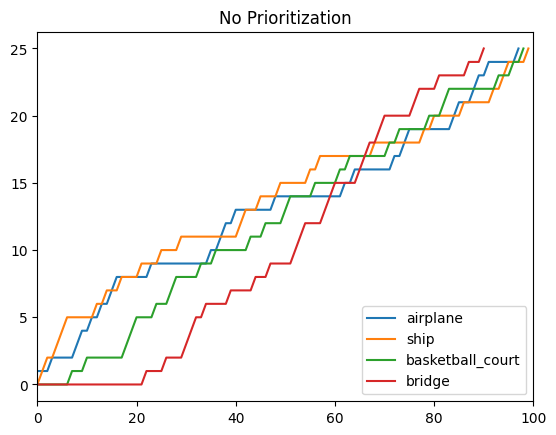

In [10]:
similarity = np.flip(np.arange(len(test_data)))
similarity = np.stack([similarity]*4).T
downData = downCount(similarity, test_data, ['airplane', 'ship', 'basketball_court', 'bridge'])
plt.title(f'No Prioritization')
plt.xlim(0,100)
plt.plot(downData['airplane']['track'], label='airplane')
plt.plot(downData['ship']['track'], label='ship')
plt.plot(downData['basketball_court']['track'], label='basketball_court')
plt.plot(downData['bridge']['track'], label='bridge')
plt.legend(loc="lower right")
plt.show()

In [11]:
print('Downlink by completion percent:')
print('Airplane: ', downData['airplane']['count'])
print('Ship: ', downData['ship']['count'])
print('Basketball Court: ', downData['basketball_court']['count'])
print('Bridge: ', downData['bridge']['count'])

Downlink by completion percent:
Airplane:  {'50%': 75, '75%': 89, '90%': 97, '100%': 98}
Ship:  {'50%': 78, '75%': 94, '90%': 99, '100%': 100}
Basketball Court:  {'50%': 73, '75%': 93, '90%': 98, '100%': 99}
Bridge:  {'50%': 69, '75%': 81, '90%': 90, '100%': 91}


In [12]:
print('Efficiency:')
print('Airplane: ', downData['airplane']['efficiency'])
print('Ship: ', downData['ship']['efficiency'])
print('Basketball Court: ', downData['basketball_court']['efficiency'])
print('Bridge: ', downData['bridge']['efficiency'])

Efficiency:
Airplane:  {'100%': 0.25510204081632654, '75%': 0.21067415730337077}
Ship:  {'100%': 0.25, '75%': 0.19946808510638298}
Basketball Court:  {'100%': 0.25252525252525254, '75%': 0.20161290322580644}
Bridge:  {'100%': 0.27472527472527475, '75%': 0.23148148148148148}


In [13]:
y_true

array([0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 1,
       3, 0, 2, 1, 3, 2, 2, 1, 3, 3, 3, 2, 3, 0, 2, 0, 0, 3, 0, 1, 1, 2,
       3, 1, 2, 3, 0, 1, 2, 2, 3, 3, 3, 1, 2, 1, 3, 3, 3, 2, 0, 2, 0, 3,
       3, 3, 1, 3, 3, 2, 0, 2, 0, 0, 3, 3, 1, 2, 1, 3, 2, 2, 0, 0, 1, 3,
       0, 0, 3, 0, 1, 2, 1, 1, 2, 0, 2, 1])

In [14]:
base_model = 'RN50'
with open(f'./CLIP/sim_{base_model}_{device}.pkl', 'rb') as file:
    similarity = pickle.load(file)
similarity.shape

(4, 100)

In [15]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity.T, k=1)})
top_k_stats.append({'k': 2, 'score': top_k_accuracy_score(y_true, similarity.T, k=2)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity.T, k=3)})
top_k_stats

[{'k': 1, 'score': np.float64(1.0)},
 {'k': 2, 'score': np.float64(1.0)},
 {'k': 3, 'score': np.float64(1.0)}]

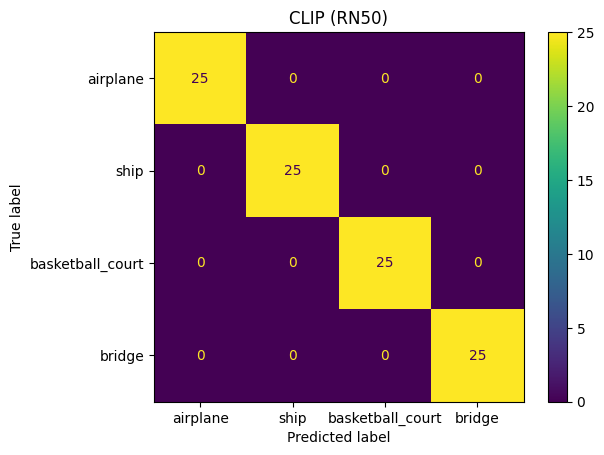

In [16]:
cm = confusion_matrix(y_true, np.argmax(similarity.T, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['airplane', 'ship', 'basketball_court', 'bridge'] )
cm_display.plot()
plt.title(f'CLIP ({base_model})')
plt.show()

In [17]:
avg_correct_cos = 0
for i, sim in enumerate(similarity.T):
    avg_correct_cos += sim[y_true[i]]

avg_correct_cos /= len(similarity.T)
avg_correct_cos

np.float32(0.6758385)

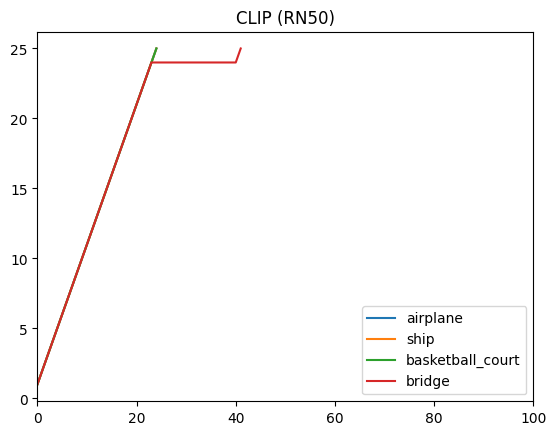

In [18]:
plt.title(f'CLIP ({base_model})')
downData = downCount(similarity.T, test_data, ['airplane', 'ship', 'basketball_court', 'bridge'])
plt.xlim(0,100)
plt.plot(downData['airplane']['track'], label='airplane')
plt.plot(downData['ship']['track'], label='ship')
plt.plot(downData['basketball_court']['track'], label='basketball_court')
plt.plot(downData['bridge']['track'], label='bridge')
plt.legend(loc="lower right")
plt.show()

In [19]:
print('Downlink by completion percent:')
print('Airplane: ', downData['airplane']['count'])
print('Ship: ', downData['ship']['count'])
print('Basketball Court: ', downData['basketball_court']['count'])
print('Bridge: ', downData['bridge']['count'])

Downlink by completion percent:
Airplane:  {'50%': 18, '75%': 22, '90%': 24, '100%': 25}
Ship:  {'50%': 18, '75%': 22, '90%': 24, '100%': 25}
Basketball Court:  {'50%': 18, '75%': 22, '90%': 24, '100%': 25}
Bridge:  {'50%': 18, '75%': 22, '90%': 41, '100%': 42}


In [20]:
print('Efficiency:')
print('Airplane: ', downData['airplane']['efficiency'])
print('Ship: ', downData['ship']['efficiency'])
print('Basketball Court: ', downData['basketball_court']['efficiency'])
print('Bridge: ', downData['bridge']['efficiency'])

Efficiency:
Airplane:  {'100%': 1.0, '75%': 0.8522727272727273}
Ship:  {'100%': 1.0, '75%': 0.8522727272727273}
Basketball Court:  {'100%': 1.0, '75%': 0.8522727272727273}
Bridge:  {'100%': 0.5952380952380952, '75%': 0.8522727272727273}


In [21]:
base_model = '1280'
with open(f'./YOLO/sim_{base_model}_{device}.pkl', 'rb') as file:
    similarity = pickle.load(file)
similarity.shape

(100, 4)

In [22]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity, k=1)})
top_k_stats.append({'k': 2, 'score': top_k_accuracy_score(y_true, similarity, k=2)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity, k=3)})
top_k_stats

[{'k': 1, 'score': np.float64(0.54)},
 {'k': 2, 'score': np.float64(0.89)},
 {'k': 3, 'score': np.float64(0.97)}]

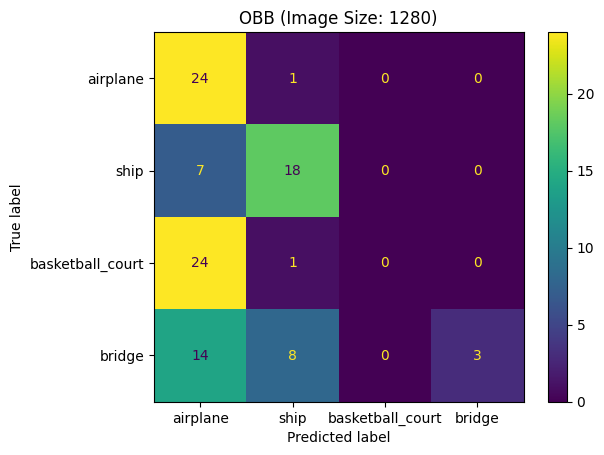

In [23]:
cm = confusion_matrix(y_true, np.argmax(similarity, axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['airplane', 'ship', 'basketball_court', 'bridge'] )
cm_display.plot()
plt.title(f'OBB (Image Size: {base_model})')
plt.show()

In [24]:
avg_correct_cos = 0
for i, sim in enumerate(similarity):
    avg_correct_cos += sim[y_true[i]]

avg_correct_cos /= len(similarity)
avg_correct_cos

np.float64(0.1408489482291529)

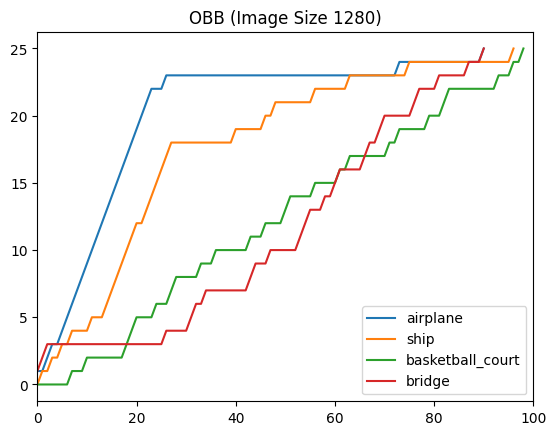

In [25]:
downData = downCount(similarity, test_data, ['airplane', 'ship', 'basketball_court', 'bridge'])
plt.title(f'OBB (Image Size {base_model})')
plt.xlim(0,100)
plt.plot(downData['airplane']['track'], label='airplane')
plt.plot(downData['ship']['track'], label='ship')
plt.plot(downData['basketball_court']['track'], label='basketball_court')
plt.plot(downData['bridge']['track'], label='bridge')
plt.legend(loc="lower right")
plt.show()

In [26]:
print('Downlink by completion percent:')
print('Airplane: ', downData['airplane']['count'])
print('Ship: ', downData['ship']['count'])
print('Basketball Court: ', downData['basketball_court']['count'])
print('Bridge: ', downData['bridge']['count'])

Downlink by completion percent:
Airplane:  {'50%': 20, '75%': 26, '90%': 90, '100%': 91}
Ship:  {'50%': 40, '75%': 63, '90%': 96, '100%': 97}
Basketball Court:  {'50%': 73, '75%': 93, '90%': 98, '100%': 99}
Bridge:  {'50%': 69, '75%': 81, '90%': 90, '100%': 91}


In [27]:
print('Efficiency:')
print('Airplane: ', downData['airplane']['efficiency'])
print('Ship: ', downData['ship']['efficiency'])
print('Basketball Court: ', downData['basketball_court']['efficiency'])
print('Bridge: ', downData['bridge']['efficiency'])

Efficiency:
Airplane:  {'100%': 0.27472527472527475, '75%': 0.7211538461538461}
Ship:  {'100%': 0.25773195876288657, '75%': 0.2976190476190476}
Basketball Court:  {'100%': 0.25252525252525254, '75%': 0.20161290322580644}
Bridge:  {'100%': 0.27472527472527475, '75%': 0.23148148148148148}
